<a href="https://colab.research.google.com/github/l-longo/neural-network-crash-course/blob/main/Shapley_ANN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**WORK IN PROGRESS**: do not circulate without the permission of the author.


# Shapley values

Shapley values are a concept from coalitional game theory that can be applied to machine learning models to explain individual feature contribution to the prediction. In this setting the game is the prediction task of a machine learning model, the players are the features of the model at an instance of the dataset and the gain is the prediction from a coalition of features. The Shapley value for feature $x_k$ is the weighted average of the marginal contributions of that feature when it is added to all the possible coalitions. A detailed explanation can be found at [Shapley values](https://christophm.github.io/interpretable-ml-book/shapley.html#shapley). 

One way to estimate Shapley values is with the Shap (SHapley Additive exPlanations) approach by Lundberg and Lee (2016). In this part of the tutorial we see the theory behind kernel based estimation of Shap and its application to the loan dataset.

## KernelSHAP

[KernelSHAP](https://christophm.github.io/interpretable-ml-book/shap.html#kernelshap) estimates features contribution by randomly generating sample coalitions $z_{k}^{\prime} \in\{0,1\}^{M}$ (with $\quad k \in\{1, \ldots, K\}$). These are vectors of 1 and 0: 1 when the feature is present and 0 when the feature is absent. The coalitions are sampled $K$ times and they are used to generate a prediction from a model. In order to get original data instances the vector of random coalition is transformed with a function that maps 1's to the corresponding feature values and 0's to the values of another instance from the sample of the data specified: $h_{x}(z^{'}) = z$. In the image (from [KernelSHAP](https://christophm.github.io/interpretable-ml-book/shap.html#kernelshap)) below it is easy to understand the concept:

![picture](https://drive.google.com/uc?export=view&id=1XjfQCNmWCUWZj49elPuNEDZ4by6pkqzw) 

The random coalitions are evaluated with the following SHAP kernel: 

$$
\pi_{x}\left(z^{\prime}\right)=\frac{(M-1)}{\left(\begin{array}{l}M \\ \left|z^{\prime}\right|\end{array}\right)\left|z^{\prime}\right|\left(M-\left|z^{\prime}\right|\right)}
$$

where $ \left|z^{\prime}\right| $ is the number of present feature in coalition $z^{'}$ while $M$ is the number of features. This weighting function assigns more weights to the small (few 1's) and large (many 1's) coalitions. The intuition is that we learn more about a feature by studying their effect in isolation. Therefore we have the set of equations:

$$
g\left(z^{\prime}\right)=\phi_{0}+\sum_{j=1}^{M} \phi_{j} z_{j}^{\prime}
$$

$$
L\left(f, g, \pi_{x}\right)=\sum_{z^{\prime} \in Z}\left[f\left(h_{x}\left(z^{\prime}\right)\right)-g\left(z^{\prime}\right)\right]^{2} \pi_{x}\left(z^{\prime}\right)
$$

and we minimize $L(.)$ to obtain the $\phi's$ as the Shapley values.

The steps for KernelSHAP can be summarized as follows:
* choose a (machine learning) model to predict some data;

* choose a data instance in the test set such that you want to explain the prediction;

* choose a sample of the (training) data to replace absent features for the instance of the dataset;

* randomly draw $K$ coalitions by using the features for the selected data instance for the 1's and randomly pick from the sample the features for the 0's (imagine that you are generating a dataset with $K$ rows and columns equal to the number of features);

* get the prediction for each coalition according to the model $f\left(h_{x}\left(z_{k}^{\prime}\right)\right)$;

* compute $\pi_{x}(z^{\prime})$ and $g(z^{\prime})$;

* compute $L(.)$ and find the SHAP.



## Example with the loan dataset

We have to install the package shap everytime we restore the data on google colab:

In [ ]:
pip install shap

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import random
import os
import pandas as pd
from google.colab import files
import tensorflow as tf
import random as python_random
from keras.models import Sequential
from keras.layers import Dense 
from sklearn.preprocessing import MinMaxScaler
import math
from matplotlib import pyplot
import sympy
from keras.utils.vis_utils import plot_model
import datetime
import shap

In [ ]:
os.environ['PYTHONHASHSEED']='34'
os.environ['CUDA_VISIBLE_DEVICE']=''
np.random.seed(100)
random.seed(30)
python_random.seed(30)
tf.random.set_seed(30)

In [ ]:
#uploaded = files.upload()
df = pd.read_csv('loan_data.csv')
df

,credit.policy,purpose,int.rate,installment,log.annual.inc,dti,fico,days.with.cr.line,revol.bal,revol.util,inq.last.6mths,delinq.2yrs,pub.rec,not.fully.paid
0,1,debt_consolidation,0.1189,829.10,11.350407,19.48,737,5639.958333,28854,52.1,0,0,0,0
1,1,credit_card,0.1071,228.22,11.082143,14.29,707,2760.000000,33623,76.7,0,0,0,0
2,1,debt_consolidation,0.1357,366.86,10.373491,11.63,682,4710.000000,3511,25.6,1,0,0,0
3,1,debt_consolidation,0.1008,162.34,11.350407,8.10,712,2699.958333,33667,73.2,1,0,0,0
4,1,credit_card,0.1426,102.92,11.299732,14.97,667,4066.000000,4740,39.5,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9573,0,all_other,0.1461,344.76,12.180755,10.39,672,10474.000000,215372,82.1,2,0,0,1
9574,0,all_other,0.1253,257.70,11.141862,0.21,722,4380.000000,184,1.1,5,0,0,1
9575,0,debt_consolidation,0.1071,97.81,10.596635,13.09,687,3450.041667,10036,82.9,8,0,0,1
9576,0,home_improvement,0.1600,351.58,10.819778,19.18,692,1800.000000,0,3.2,5,0,0,1


We do the same routine by transforming the inputs in values between 0 and 1. The target variable is *credit policy*.

In [ ]:
Y = df.iloc[:,0]
X_ns = df.iloc[:,2:10]
scaler = MinMaxScaler(feature_range=(0, 1))
X = pd.DataFrame( scaler.fit_transform(X_ns), columns=list(X_ns.columns))

The new dataset looks like this:

In [ ]:
Data0 = pd.concat([Y,X], axis = 1)
Data0

,credit.policy,int.rate,installment,log.annual.inc,dti,fico,days.with.cr.line,revol.bal,revol.util
0,1,0.376598,0.879888,0.544762,0.650200,0.581395,0.312754,0.023898,0.437815
1,1,0.301151,0.229916,0.506334,0.476969,0.441860,0.147818,0.027848,0.644538
2,1,0.484015,0.379883,0.404820,0.388184,0.325581,0.259495,0.002908,0.215126
3,1,0.260870,0.158653,0.544762,0.270360,0.465116,0.144379,0.027885,0.615126
4,1,0.528133,0.094378,0.537503,0.499666,0.255814,0.222613,0.003926,0.331933
...,...,...,...,...,...,...,...,...,...
9573,0,0.550512,0.355977,0.663709,0.346796,0.279070,0.589602,0.178383,0.689916
9574,0,0.417519,0.261804,0.514888,0.007009,0.511628,0.240596,0.000152,0.009244
9575,0,0.301151,0.088851,0.436785,0.436916,0.348837,0.187337,0.008312,0.696639
9576,0,0.639386,0.363354,0.468750,0.640187,0.372093,0.092838,0.000000,0.026891


We re-sample randomly in order to generate train, validation and test set:

In [ ]:
n_rows = df.shape[0]
Data =  Data0.to_numpy()[np.random.choice(Data0.to_numpy().shape[0], n_rows, replace=True)]
pd.DataFrame(Data)

,0,1,2,3,4,5,6,7,8
0,1.0,0.187980,0.089597,0.462903,0.725968,0.488372,0.343396,0.012717,0.401681
1,1.0,0.461637,0.092745,0.277970,0.194259,0.534884,0.147820,0.001283,0.813445
2,0.0,0.434783,0.164765,0.462903,0.921228,0.465116,0.309323,0.013677,0.259664
3,1.0,0.313939,0.124525,0.322400,0.600801,0.441860,0.115288,0.004583,0.668908
4,1.0,0.152174,0.238699,0.526833,0.202270,0.604651,0.170098,0.003550,0.339496
...,...,...,...,...,...,...,...,...,...
9573,1.0,0.336317,0.587374,0.506342,0.147196,0.697674,0.366018,0.001555,0.060504
9574,1.0,0.236573,0.030839,0.436649,0.695594,0.674419,0.438177,0.012269,0.309244
9575,1.0,0.439258,0.288652,0.417657,0.712951,0.348837,0.115231,0.006658,0.636975
9576,1.0,0.395141,0.451318,0.516950,0.112150,0.488372,0.280112,0.007069,0.426891


In [ ]:
Y_r = Data[:,0]
X_r = Data[:,1:]

y_train = Y_r[:int(n_rows*0.7)]
y_val = Y_r[int(n_rows*0.7):int(n_rows*0.9)]
y_test = Y_r[int(n_rows*0.9):]

x_train = X_r[:int(n_rows*0.7),:]
x_val = X_r[int(n_rows*0.7):int(n_rows*0.9)]
x_test = X_r[int(n_rows*0.9):]

and then we can finally run the model:

In [ ]:
model4 = Sequential()
model4.add(Dense(30, input_dim=x_train.shape[1], activation='relu'))
model4.add(Dense(10, input_dim=x_train.shape[1], activation='relu'))
model4.add(Dense(1, activation='sigmoid'))
model4.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
history4 = model4.fit(x_train, y_train, epochs=50, batch_size=150, verbose=1, validation_data = (x_val,y_val))

Epoch 1/50
45/45 [==============================] - 1s 8ms/step - loss: 0.6734 - accuracy: 0.5953 - val_loss: 0.5884 - val_accuracy: 0.7996
Epoch 2/50
45/45 [==============================] - 0s 2ms/step - loss: 0.5541 - accuracy: 0.8203 - val_loss: 0.5074 - val_accuracy: 0.7996
Epoch 3/50
45/45 [==============================] - 0s 2ms/step - loss: 0.4829 - accuracy: 0.8102 - val_loss: 0.4784 - val_accuracy: 0.7996
Epoch 4/50
45/45 [==============================] - 0s 2ms/step - loss: 0.4511 - accuracy: 0.8140 - val_loss: 0.4608 - val_accuracy: 0.7996
Epoch 5/50
45/45 [==============================] - 0s 2ms/step - loss: 0.4248 - accuracy: 0.8205 - val_loss: 0.4454 - val_accuracy: 0.7996
Epoch 6/50
45/45 [==============================] - 0s 2ms/step - loss: 0.4104 - accuracy: 0.8276 - val_loss: 0.4344 - val_accuracy: 0.8053
Epoch 7/50
45/45 [==============================] - 0s 2ms/step - loss: 0.4132 - accuracy: 0.8224 - val_loss: 0.4330 - val_accuracy: 0.8053
Epoch 8/50
45/45 [==

### SHAP force plot

Now the interesting part comes: we compute SHAP by using the Kernel based estimator. An important parameter need to be set: *n_k* that is the number of randomly drawn coalitions. We will give a portion of the training data as instances from which the random coalitions are drawn. We fed into the model the first 50 instances with 500 randomly drawn coalitions. In this sense the model will be evaluated 50*500 times.

The output is the set of SHAP values per each features. A nice graph will tell us with arrows the features contribution in positive (red) or negative (blue) to the prediction of an instance:

In [ ]:
n_k = 1000
X_display = pd.DataFrame(x_test, columns=list(Data0.columns[1:]))
shap.initjs()
explainer = shap.KernelExplainer(model4, x_train[:50,:])
shap_values = explainer.shap_values(x_test[2,:], nsamples=n_k)
c = np.array([shap_values])[0,0,:]
shap.force_plot(explainer.expected_value, c, features=X_display.iloc[2,:])

We predicted the instance indexed at 2 in the test set. The predicted outcome of the model is 0.48 and the graph nicely shows the forces - in terms of features - that moves up and down the prediction. The *base value* is 0.8237 and is the *value that would be predicted if we did not know any features to the current output*, Lundberg and Lee (2016): therefore is the expected value of the predicted model over the training sample:

In [ ]:
explainer.expected_value

array([0.82374539])

We can also compute SHAP values for more instances. We have to define a window of the test set for that we would like to get the features importance:

In [ ]:
explain_size = 50
shap_values50 = explainer.shap_values(x_test[:explain_size,:], nsamples=n_k)

With the following code we can get the SHAP for multiple instances in the test set. Notice that the graph below is just a vertical rotation of the previous one computed for more instances. This is an interactive graph and you can set some visualization parameters. The default gives you a cluster of instances grouping together instances with features that have a similar prediction power:

In [ ]:
shap.initjs()
c1 = np.resize( np.array([shap_values50])[0,:,:], (np.array([shap_values50])[0,:,:].shape[1],x_test.shape[1]))
shap.force_plot(explainer.expected_value, c1, X_display.iloc[:explain_size,:])

### Features importance

Feature importance can be computed as the sum of SHAP in absolute values for more instances:

$$
I_{j}=\sum_{i=1}^{n}\left|\phi_{j}^{(i)}\right|
$$

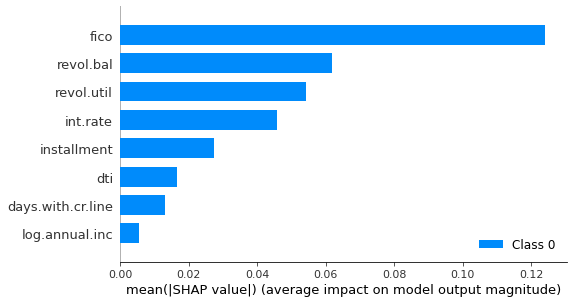

In [ ]:
shap.initjs()
shap.summary_plot(shap_values50,X_display.iloc[:explain_size,:])

Indeed you can see SHAP as local explanation of features importance: in this sense you can see them as coefficients if you aggregate them over the instances. It is not yet clear how to make assumptions on the distribution.

In [ ]:
pd.DataFrame(c1, columns = list(X_display.columns))

,int.rate,installment,log.annual.inc,dti,fico,days.with.cr.line,revol.bal,revol.util
0,0.015955,0.016638,0.001328,0.010896,0.090457,0.016237,0.008760,0.001468
1,0.041067,-0.010698,-0.002431,0.011242,0.028764,0.007750,0.034373,0.041773
2,-0.094843,-0.001832,0.011789,0.001460,-0.396693,-0.000230,0.015530,0.117183
3,-0.083532,0.010390,0.006159,-0.003073,-0.204042,0.007356,-0.017494,0.089022
4,-0.025942,-0.070521,-0.011443,-0.000677,-0.432251,-0.051692,0.056886,-0.132832
5,-0.062766,-0.000182,0.002082,0.014394,0.011264,0.008237,-0.000247,0.079703
6,-0.069200,0.038870,0.010471,-0.009888,-0.072276,-0.001096,-0.736580,0.049727
7,0.015714,0.027094,0.000949,0.006597,0.126781,-0.014510,0.040785,-0.077691
8,-0.007644,-0.011637,-0.004167,0.012692,0.240080,0.034411,-0.025213,-0.075036
9,0.016141,0.040507,0.002512,0.004119,0.109896,0.011730,0.028790,-0.050525


### SHAP summary plot

With the summary plot we get a taste of the distribution of the SHAP values for all the features (y-axis). The color indicates low/high feature value and every point is a SHAP for a feature at every instance in the test set:

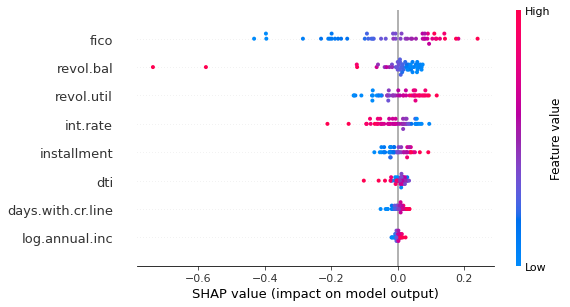

In [ ]:
shap.initjs()
shap.summary_plot(c1, X_display.iloc[:explain_size,:])

We can summarize by also plotting a scatter plot to evaluate the SHAP of a feature of different instances:

<Figure size 432x288 with 0 Axes>

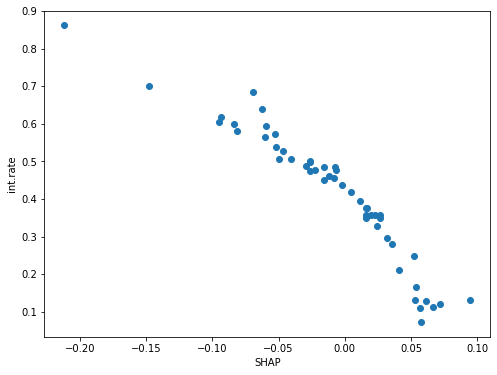

In [ ]:
fig = plt.figure()
plt.figure(figsize=(8, 6))
plt.scatter(c1[:,0], X_display.iloc[:explain_size,0])
plt.ylabel('int.rate')
plt.xlabel('SHAP')
plt.show()

### Group SHAP

SHAP can be computed for groups of features. I use the function from this [kaggle notebook](https://www.kaggle.com/estevaouyra/shap-advanced-uses-grouping-and-correlation) to generate SHAP for groups of features, manually selecting the groups:

In [ ]:
from itertools import repeat, chain
revert_dict = lambda d: dict(chain(*[zip(val, repeat(key)) for key, val in d.items()]))
        
def grouped_shap(shap_vals, features, groups):
    groupmap = revert_dict(groups)
    shap_Tdf = pd.DataFrame(shap_vals, columns=pd.Index(features, name='features')).T
    shap_Tdf['group'] = shap_Tdf.reset_index().features.map(groupmap).values
    shap_grouped = shap_Tdf.groupby('group').sum().T
    return shap_grouped

In [ ]:
groups_by_type = {
    'A': ['int.rate', 'installment', 'log.annual.inc', 'dti'],
    'B': ['fico', 'days.with.cr.line', 'revol.bal', 'revol.util']
}

In [ ]:
shap_type = grouped_shap(shap_values, list(X_display.columns), groups_by_type)

In [ ]:
shap.initjs()
c_type = np.array([shap_type])[0,0,:]
shap.force_plot(explainer.expected_value, c_type, ['A','B'])

In [ ]:
np.mean(c[:4])

-0.020856572205056732

In [ ]:
c_type

array([-0.08342629, -0.26421124])

In [ ]:
shap_type50 = grouped_shap(c1, list(X_display.columns), groups_by_type)

In [ ]:
shap.initjs()
c1_type = np.resize( np.array([shap_type50])[0,:,:], (np.array([shap_type50])[0,:,:].shape[1],2))
shap.force_plot(explainer.expected_value, shap_type50.to_numpy(), features=['A','B'])